In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import tensorflow as tf
import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from importlib import reload

# custom module for capstone 2
import cap2tools as c2t
reload(c2t)

Using TensorFlow backend.


<module 'cap2tools' from 'C:\\Users\\Nils\\Documents\\GitHub\\Springboard-Capstone-2-local-yelp\\cap2tools.py'>

In [2]:
# configure GPU memory usage by tensorflow
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
K.tensorflow_backend.set_session(K.tf.Session(config=config))

In [3]:
# define paths to image directories
train_path = 'downsampled/train'
valid_path = 'downsampled/val'

# create data generators
train_batches, valid_batches = c2t.build_datagens(train_path, valid_path, augment=True)

Found 5480 images belonging to 5 classes.
Found 525 images belonging to 5 classes.


In [4]:
# test various widths for model
widths = [400, 600, 800, 1000, 1200]
replicates = 3
n_epochs = 10

histories = dict()
model_paths = dict()

for width in widths:
    condition = 'width_{}'.format(str(width))
    histories[width] = c2t.run_in_replicate(width, condition, train_batches, valid_batches, 
                                            replicates=replicates, n_epochs=n_epochs, new_weights=False, 
                                            trainable=True)
    
    # add key-value pairs to model_paths
    for i in range(1, replicates+1):
        key = condition + ' - ' + str(i)
        value = 'models/vgg16_{}_{}.h5'.format(condition, str(i))
        model_paths[key] = value

2018-09-14 23:26:13 - Started training models/vgg16_width_400_1
2018-09-14 23:50:43 - Started training models/vgg16_width_400_2
2018-09-15 00:15:15 - Started training models/vgg16_width_400_3
2018-09-15 00:39:55 - Started training models/vgg16_width_600_1
2018-09-15 01:04:30 - Started training models/vgg16_width_600_2
2018-09-15 01:28:59 - Started training models/vgg16_width_600_3
2018-09-15 01:53:30 - Started training models/vgg16_width_800_1
2018-09-15 02:18:43 - Started training models/vgg16_width_800_2
2018-09-15 02:43:53 - Started training models/vgg16_width_800_3
2018-09-15 03:09:47 - Started training models/vgg16_width_1000_1
2018-09-15 03:35:34 - Started training models/vgg16_width_1000_2
2018-09-15 04:01:19 - Started training models/vgg16_width_1000_3
2018-09-15 04:27:08 - Started training models/vgg16_width_1200_1
2018-09-15 04:53:48 - Started training models/vgg16_width_1200_2
2018-09-15 05:20:34 - Started training models/vgg16_width_1200_3


In [4]:
# evaluate trained models on validation dataset
model_paths = {'width 400 - 1': 'models/vgg16_width_400_1.h5', 
               'width 400 - 2': 'models/vgg16_width_400_2.h5',
               'width 400 - 3': 'models/vgg16_width_400_3.h5',
               'width 600 - 1': 'models/vgg16_width_600_1.h5', 
               'width 600 - 2': 'models/vgg16_width_600_2.h5',
               'width 600 - 3': 'models/vgg16_width_600_3.h5',
               'width 800 - 1': 'models/vgg16_width_800_1.h5', 
               'width 800 - 2': 'models/vgg16_width_800_2.h5',
               'width 800 - 3': 'models/vgg16_width_800_3.h5',
               'width 1000 - 1': 'models/vgg16_width_1000_1.h5', 
               'width 1000 - 2': 'models/vgg16_width_1000_2.h5',
               'width 1000 - 3': 'models/vgg16_width_1000_3.h5',
               'width 1200 - 1': 'models/vgg16_width_1200_1.h5', 
               'width 1200 - 2': 'models/vgg16_width_1200_2.h5',
               'width 1200 - 3': 'models/vgg16_width_1200_3.h5',
               'width 1500 - 1': 'models/vgg16_width_1500_1.h5', 
               'width 1500 - 2': 'models/vgg16_width_1500_2.h5',
               'width 1500 - 3': 'models/vgg16_width_1500_3.h5',
               'width 2000 - 1': 'models/vgg16_width_2000_1.h5', 
               'width 2000 - 2': 'models/vgg16_width_2000_2.h5'}

In [5]:
model_metrics = c2t.eval_models(model_paths, valid_path)

Building image generator...
Found 525 images belonging to 5 classes.
Loading models/vgg16_width_400_1.h5
Evaluating models/vgg16_width_400_1.h5
Loading models/vgg16_width_400_2.h5
Evaluating models/vgg16_width_400_2.h5
Loading models/vgg16_width_400_3.h5
Evaluating models/vgg16_width_400_3.h5
Loading models/vgg16_width_600_1.h5
Evaluating models/vgg16_width_600_1.h5
Loading models/vgg16_width_600_2.h5
Evaluating models/vgg16_width_600_2.h5
Loading models/vgg16_width_600_3.h5
Evaluating models/vgg16_width_600_3.h5
Loading models/vgg16_width_800_1.h5
Evaluating models/vgg16_width_800_1.h5
Loading models/vgg16_width_800_2.h5
Evaluating models/vgg16_width_800_2.h5
Loading models/vgg16_width_800_3.h5
Evaluating models/vgg16_width_800_3.h5
Loading models/vgg16_width_1000_1.h5
Evaluating models/vgg16_width_1000_1.h5
Loading models/vgg16_width_1000_2.h5
Evaluating models/vgg16_width_1000_2.h5
Loading models/vgg16_width_1000_3.h5
Evaluating models/vgg16_width_1000_3.h5
Loading models/vgg16_widt

In [7]:
table = c2t.eval_table(model_metrics, 'width')
table

,acc,loss,mpcr
width,,,
width 400 - 1,0.874,0.315,0.874
width 400 - 2,0.829,0.439,0.829
width 400 - 3,0.880,0.287,0.880
width 600 - 1,0.890,0.308,0.890
width 600 - 2,0.909,0.260,0.909
width 600 - 3,0.848,0.350,0.848
width 800 - 1,0.893,0.298,0.893
width 800 - 2,0.901,0.271,0.901
width 800 - 3,0.897,0.288,0.897


In [5]:
# test more widths for model
widths = [1500, 2000, 2500, 3000, 3500, 4000]
replicates = 3
n_epochs = 10


histories = dict()

for width in widths:
    condition = 'width_{}'.format(str(width))
    histories[width] = c2t.run_in_replicate(width, condition, train_batches, valid_batches, 
                                            replicates=replicates, n_epochs=n_epochs, new_weights=False, 
                                            trainable=True)
    
    # add key-value pairs to model_paths
    for i in range(1, replicates+1):
        key = condition + ' - ' + str(i)
        value = 'models/vgg16_{}_{}.h5'.format(condition, str(i))
        model_paths[key] = value

2018-09-16 01:11:21 - Started training models/vgg16_width_1500_1
2018-09-16 01:39:41 - Started training models/vgg16_width_1500_2
2018-09-16 02:07:31 - Started training models/vgg16_width_1500_3
2018-09-16 02:35:44 - Started training models/vgg16_width_2000_1
2018-09-16 03:05:14 - Started training models/vgg16_width_2000_2
2018-09-16 03:34:44 - Started training models/vgg16_width_2000_3


StopIteration: 

In [ ]:
# save training history
histpath = 'VGG16_width_comparison_history.json'
hist_df = pd.read_json(histpath)
hist_df_2 = pd.DataFrame(histories).transpose()
hist_df = pd.concat([hist_df, hist_df_2], axis=0)

hist_df

# hist_df.to_json(histpath)

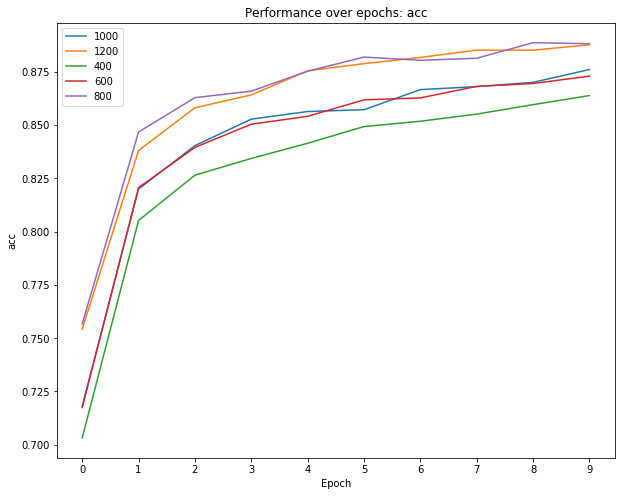

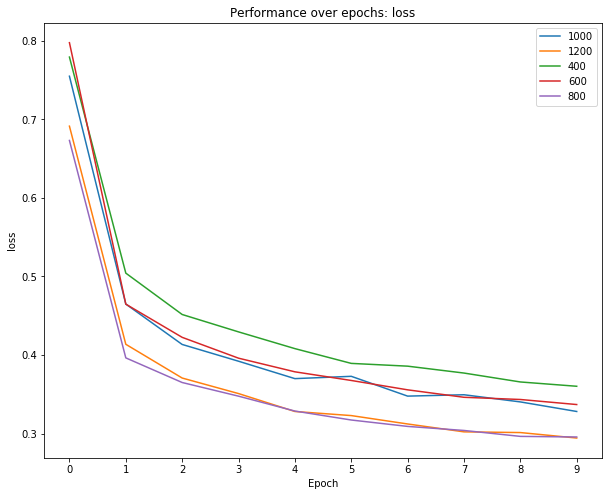

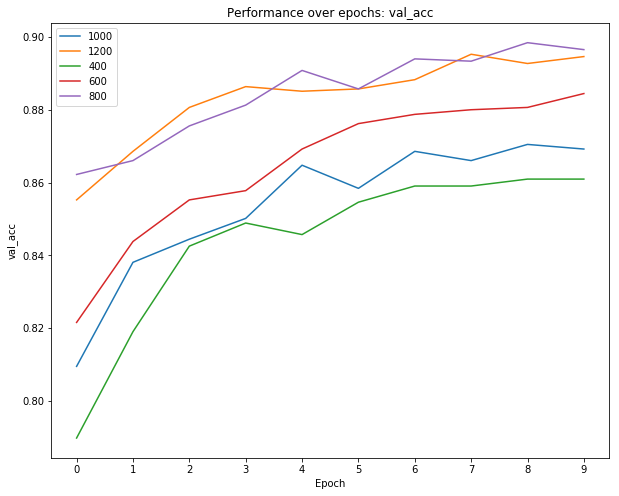

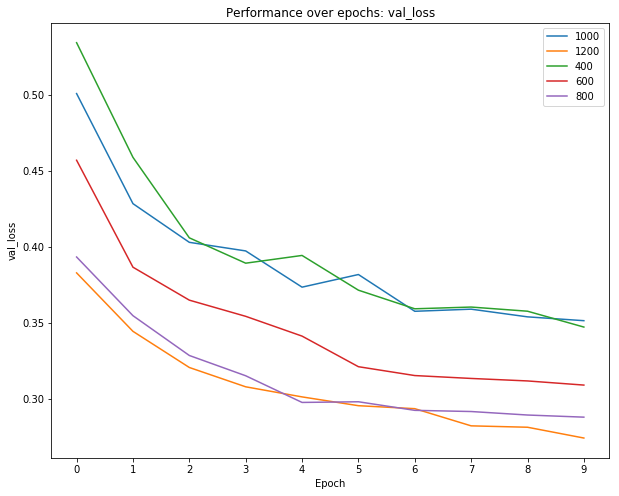

In [9]:
hist_df = pd.read_json('VGG16_width_comparison_history.json')

# plot model comparison
c2t.plot_metric('acc', hist_df)
c2t.plot_metric('loss', hist_df)
c2t.plot_metric('val_acc', hist_df)
c2t.plot_metric('val_loss', hist_df)

In [10]:
hist_df

,acc,loss,val_acc,val_loss
1000,"[0.7180656934, 0.8200121655, 0.8403892944, 0.8...","[0.7548048788, 0.46482429300000006, 0.41337373...","[0.8095238095, 0.8380952383, 0.8444444445, 0.8...","[0.5008671304, 0.4284037439, 0.4029402217, 0.3..."
1200,"[0.7541970803, 0.8380778589000001, 0.858150851...","[0.6912305903, 0.4135931269, 0.3706355415, 0.3...","[0.8552380954000001, 0.8685714286, 0.880634920...","[0.3828309492, 0.3443415765, 0.3205473965, 0.3..."
400,"[0.7031630170000001, 0.8052311436, 0.826520681...","[0.7791766848, 0.5041741578, 0.4515113435, 0.4...","[0.7898412699, 0.8190476192, 0.8425396826, 0.8...","[0.5343690635, 0.45889141990000004, 0.40590079..."
600,"[0.7174574209, 0.8206812652000001, 0.839537712...","[0.79750435, 0.4646898363, 0.422435643, 0.3959...","[0.8215873017, 0.8438095239000001, 0.855238095...","[0.4569727758, 0.386568232, 0.3648754481, 0.35..."
800,"[0.7566909976, 0.8467761557, 0.862895377100000...","[0.6730293336000001, 0.3962881131, 0.364932421...","[0.8622222223, 0.8660317461, 0.8755555556, 0.8...","[0.39328540430000003, 0.3546459608, 0.32844961..."
